In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [5]:
# Reading the image
img1 = cv2.imread("left.jpg")
img2 = cv2.imread("right.jpg")

In [6]:
# Converting the image into Grayscale
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

In [7]:
#sift descriptor
# SIFT works only on grayscale images
sift = cv2.xfeatures2d.SIFT_create()

In [8]:
# Computing keypoints and descriptors using sift
keypoints1, descriptor1 = sift.detectAndCompute(img1_gray,None)
keypoints2, descriptor2 = sift.detectAndCompute(img2_gray,None)

In [9]:
# Feature matching
# FLANN based Matcher

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

# specifies the number of times the trees in the index should be recursively traversed. 
# Higher values gives better precision, but also takes more time
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(descriptor1,descriptor2,k=2)
pts_1 = []
pts_2 = []

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts_2.append(keypoints2[m.trainIdx].pt)
        pts_1.append(keypoints1[m.queryIdx].pt)

# Estimating Fundamental matrix and Epipolar Lines using OpenCV Api

In [10]:
pts1 = np.int32(pts_1)
pts2 = np.int32(pts_2)

# Computing the fundamental matrix using 8-point algorithm method
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_8POINT)

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

In [11]:
F

array([[ 2.77799611e-07,  6.54863218e-07, -1.07818141e-03],
       [-9.14323701e-07,  7.90120039e-07,  1.37671936e-03],
       [ 2.69846876e-04, -2.14039351e-03,  1.00000000e+00]])

In [12]:
np.linalg.matrix_rank(F)

2

In [13]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

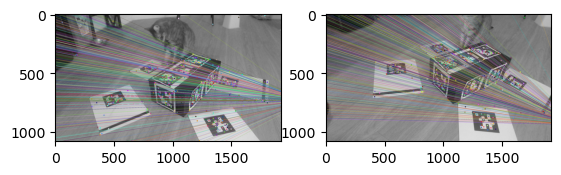

In [14]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1_gray,img2_gray,lines1,pts1,pts2)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2_gray,img1_gray,lines2,pts2,pts1)
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

# Estimating Fundamental matrix using 8-point Algorithm Implementation

In [15]:
pts_12 = np.int32(pts_1)
pts_22 = np.int32(pts_2)

In [16]:
def normalize_points(keypoints):

    kps = keypoints

    mean = kps.mean(axis=0)
    
    # Shift the points to the centre
    centered = kps - mean*np.ones(kps.shape)

    eu_dist = np.mean(np.linalg.norm(centered,axis=1))
    std = np.mean(eu_dist)

    b_temp = np.ones((kps.shape[0],1))
    
    h_kps = np.concatenate((kps, b_temp),axis = 1)
    
    T = np.array([[np.sqrt(2)/std, 0, -np.sqrt(2)*mean[0]/std],
                  [0,np.sqrt(2)/std,-np.sqrt(2)*mean[1]/std],
                 [0,0,1]])
    

    
    return (T @ h_kps.T).T, T, mean

In [17]:
p1,T1,m1 = normalize_points(pts_12)
p2,T2,m2 = normalize_points(pts_22)

In [18]:
def estimate_fundamental_matrix(p1, p2):
    # Linear Solution
    A_list = []
    for i in range(p1.shape[0]):
        u1 = p1[i][0]
        v1 = p1[i][1]
        u2 = p2[i][0]
        v2 = p2[i][1]
        A_list.append([u1*u2, v1*u2, u2, u1*v2, v1*v2, v2, u1, v1, 1])
#         A_list.append([u1*u2, v2*u1, u1, u2*v1, v1*v2, v1, u2, v2, 1])
    A = np.array(A_list)
    H = np.dot(A.T,A)
    U,S,V = np.linalg.svd(H)

    V1 = V.T
    F = V1[:,-1].reshape(3,3)

    
#      make F rank 2
    [U, S1, V] = np.linalg.svd(F,full_matrices=False)
    S = np.diag(S1)
    

    if S[0][0] <= S[1][1] and S[1][1] <= S[2][2]:
        S[0][0] = 0
    elif S[1][1] <= S[0][0] and S[1][1] <= S[2][2]:
        S[1][1] = 0
    else:
        S[2][2] = 0
    

    F = U @ S @ V

    return F

In [19]:
f_hat = estimate_fundamental_matrix(p1,p2)

In [20]:
f_hat

array([[ 0.0430373 ,  0.10145279, -0.2605165 ],
       [-0.14164895,  0.12240706,  0.61382782],
       [ 0.08788482, -0.70601113, -0.04447584]])

In [21]:
F_denormalised = T2.T @ f_hat @ T1

In [22]:
F_denormalised

array([[ 8.78216524e-07,  2.07023939e-06, -3.40848833e-03],
       [-2.89047986e-06,  2.49783098e-06,  4.35226559e-03],
       [ 8.53075296e-04, -6.76649236e-03,  3.16133100e+00]])

In [24]:
np.linalg.matrix_rank(F_denormalised)

2

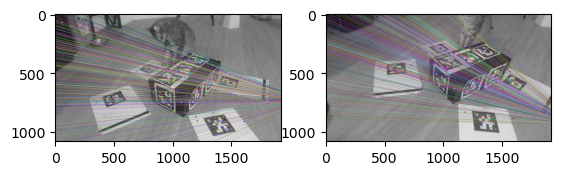

In [25]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts_22.reshape(-1,1,2), 2,F_denormalised)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1_gray,img2_gray,lines1,pts_12,pts_22)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F_denormalised)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2_gray,img1_gray,lines2,pts_22,pts_12)
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

# Calculating the Relative pose(R,t) from essential matrix

In [26]:
import os
import glob

In [29]:
def calibrate():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,6,0)
    objp = np.zeros((4*6,3), np.float32)
    objp[:, :2] = np.mgrid[0:6, 0:4].T.reshape(-1, 2)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d point in real world space
    imgpoints = []  # 2d points in image plane.

    images = glob.glob(r'./Task_3_calib/*.jpg')

    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        ret, corners = cv2.findChessboardCorners(gray, (6, 4), flags=cv2.CALIB_USE_INTRINSIC_GUESS)

            
        # If found, add object points, image points (after refining them)
        if ret:
    
            objpoints.append(objp)

            corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            imgpoints.append(corners2)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (6, 4), corners2, ret)
            plt.figure()
            plt.imshow(img)
            plt.show()

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    return [ret, mtx, dist, rvecs, tvecs]

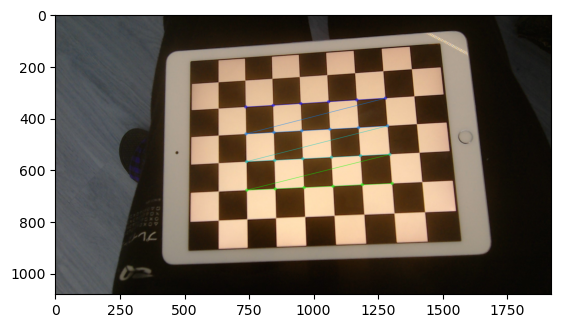

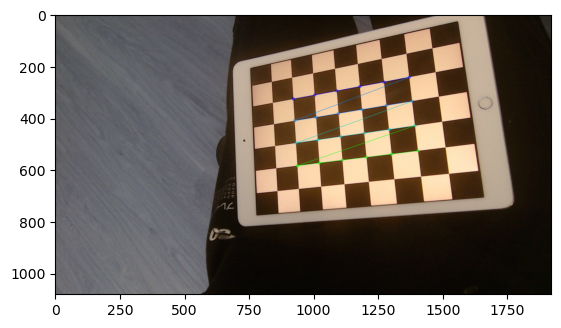

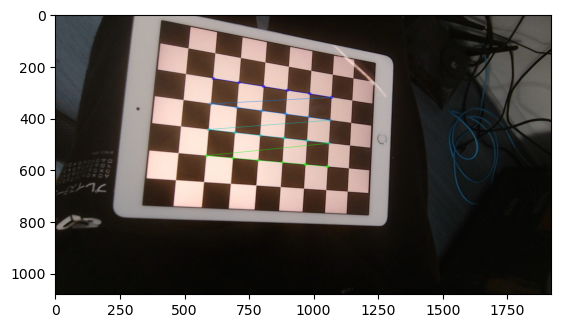

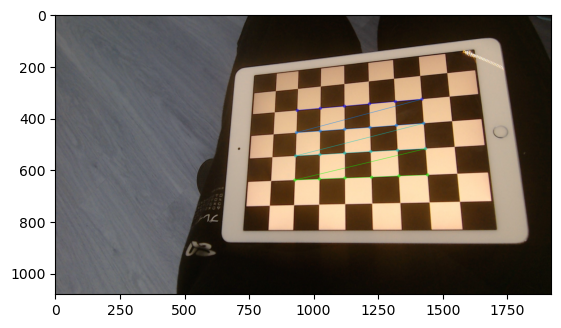

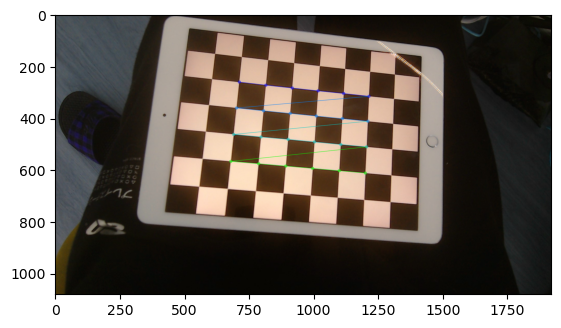

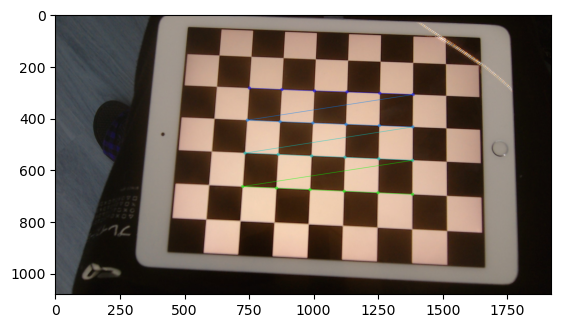

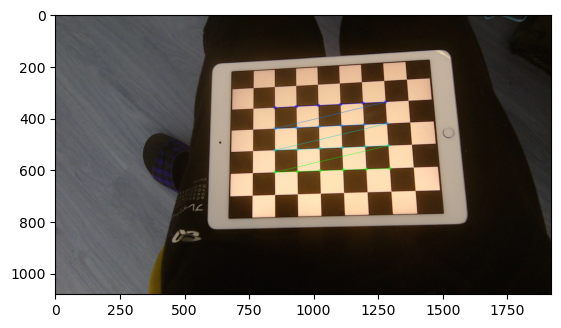

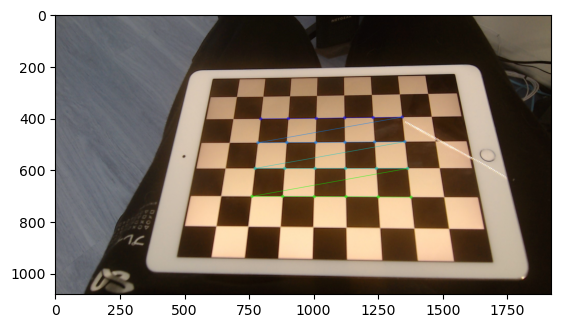

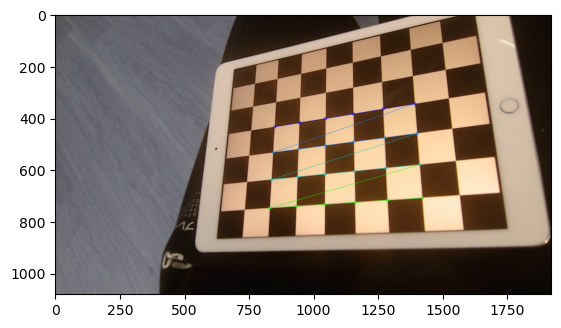

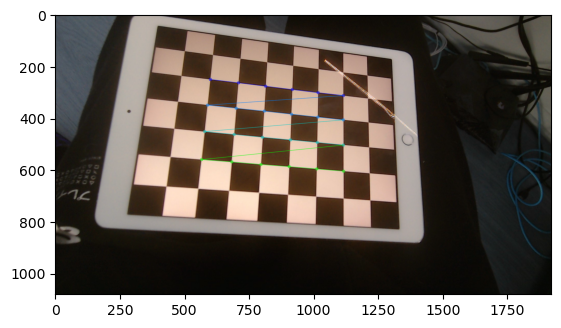

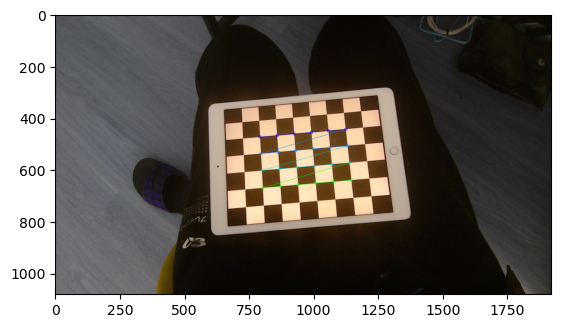

In [30]:
[ret, mtx, dist, rvecs, tvecs] = calibrate()


In [31]:
# Plotting the intrinsic camera matrix
mtx

array([[1.44134035e+03, 0.00000000e+00, 9.66931890e+02],
       [0.00000000e+00, 1.44576008e+03, 5.57498587e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [33]:
# Getting the essential matrix from the fundamental matrix using the calibration matrix K
E = mtx.T*F*mtx
print(E)

[[ 0.57711813  0.         -0.        ]
 [-0.          1.65152646  0.        ]
 [ 0.         -0.          1.        ]]


In [34]:
# Getting the R and t matrices
[R1,R2,t] = cv2.decomposeEssentialMat(E)

In [35]:
print("The rotation matrix is either")
print(R1)
print("or")
print(R2)

print("The translation matrix is")
print(t)

The rotation matrix is either
[[ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 0. -1.  0.]]
or
[[ 1.  0.  0.]
 [ 0.  0. -1.]
 [ 0.  1.  0.]]
The translation matrix is
[[1.]
 [0.]
 [0.]]


# References
1.) [Feature Matching](https://docs.opencv.org/3.3.0/dc/dc3/tutorial_py_matcher.html) <br>
2.) [Point Normalisation](http://ece631web.groups.et.byu.net/Lectures/ECEn631%2013%20-%208%20Point%20Algorithm.pdf) <br>
3.) [Computing Fundamental Matrix](https://www.youtube.com/watch?v=zX5NeY-GTO0)<br>
4.) [Camera Calibration](https://opencv24-python-tutorials.readthedocs.io/en/stable/py_tutorials/py_calib3d/py_calibration/py_calibration.html)